<a href="https://colab.research.google.com/github/shreyansh273/Coursera-Deep-Learning/blob/main/Neural%20Network%20and%20Deep%20Learning/Practise/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing packages**

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Activation functions and their gradients**

In [2]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

In [3]:
def sigmoid_backward(dA, activation_cache):
  Z = activation_cache
  s = sigmoid(Z)
  return dA*s*(1-s)

In [4]:
def relu_backward(dA, activation_cache):
  Z = activation_cache
  Z[Z<=0] = 0
  Z[Z>0] = 1
  return dA*Z

**Function to initialize paramters of the Neural Network**

In [5]:
def initialize_parameters(layer_dims):
  np.random.seed(52)
  L = len(layer_dims)
  parameters = {}
  for i in range(1,L):
    parameters["W"+str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1])*0.01 #cant initialize with zeros as the gradient wont change hence the paramters also wont change
    parameters["b"+str(i)] = np.zeros((layer_dims[i],1))
  return parameters

In [6]:
parameters = initialize_parameters([3,2,1])
print(parameters)

{'W1': array([[ 0.00519476, -0.0126875 ,  0.0024042 ],
       [-0.00803957,  0.00017344,  0.00394394]]), 'b1': array([[0.],
       [0.]]), 'W2': array([[0.01279132, 0.00659736]]), 'b2': array([[0.]])}


**Function for the linear part of forward propagation**

In [7]:
def linear_forward(A, W, b):
  Z = np.dot(W, A) +b
  cache = (A, W, b)
  return Z, cache

In [8]:
A0 = np.random.randn(3,2)*100
W1 = parameters["W1"]
b1 = parameters["b1"]
Z1, cache1 = linear_forward(A0, W1, b1)
print(Z1.shape)  #can be understood as the 5 input variables after passing through the first layer become 4 so the shape changes from (5,20) to (4,20)
print(Z1)

(2, 2)
[[ 0.34707294 -0.97686272]
 [ 0.44433862 -0.95274972]]


**Function for the non-linear part of forward propagation**

In [9]:
def linear_activation_forward(A_prev, W, b, activation):
  Z, linear_cache = linear_forward(A_prev, W, b)
  if activation == 'sigmoid':
    A = sigmoid(Z)
  elif activation == 'relu':
    A = np.maximum(Z,0)
  activation_cache = Z
  cache = (linear_cache, activation_cache)
  return A, cache

In [10]:
A1, cache = linear_activation_forward(A0, W1, b1, 'sigmoid')
print(A1.shape) 
print(A1)
A1, cache = linear_activation_forward(A0, W1, b1, 'relu')
print(A1.shape) 
print(A1)

(2, 2)
[[0.58590759 0.27351473]
 [0.60929235 0.27833217]]
(2, 2)
[[0.34707294 0.        ]
 [0.44433862 0.        ]]


**Function for the complete forward propagation**

In [11]:
def L_model_forward(X, parameters):
  caches = []
  A = X
  L = len(parameters) //2
  for i in range(1,L):
    A_prev = A
    A, cache = linear_activation_forward(A_prev, parameters['W'+ str(i)], parameters['b'+str(i)], 'relu')
    caches.append(cache)
  AL, cache = linear_activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], 'sigmoid')
  caches.append(cache)
  return AL, caches

In [12]:
AL, caches = L_model_forward(A0, parameters)
print(AL.shape)
print(AL)

(1, 2)
[[0.50184274 0.5       ]]


**Function to compute cost function for Neural Network**

In [13]:
def compute_cost(AL,Y):
  m = AL.shape[1]
  cost = -1/m*(np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1-Y, np.log(1-AL))))
  return cost

In [14]:
Y = np.array([1,0]).reshape(1,2)
cost = compute_cost(AL,Y)
print(cost)

0.691307829901911


**Backward Propagation**

In [15]:
def linear_backward(dZ, cache):
  (A_prev, W, b) = cache
  m = A_prev.shape[1]
  dW = 1/m*(np.dot(dZ, A_prev.T))
  db = 1/m*(np.sum(dZ, axis=1, keepdims=True))
  dA_prev = np.dot(W.T, dZ)
  return dA_prev, dW, db

In [16]:
def activation_backward(dA, cache, activation):
  linear_cache, activation_cache = cache
  if activation == 'sigmoid':
    dZ = sigmoid_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
  if activation == 'relu':
    dZ = relu_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
  return dA_prev, dW, db

In [17]:
def L_model_backward(AL, Y, caches):
  grads = {}
  L = len(caches)
  m = AL.shape[1]
  Y = Y.reshape(AL.shape)

  dAL = -(np.divide(Y,AL) - np.divide(1-Y, 1-AL))
  current_cache = caches[L-1]  # L-1 is because the index starts from 0 
  grads["dA"+str(L-1)], grads["dW"+str(L)], grads['db'+str(L)] = activation_backward(dAL, current_cache, 'sigmoid')

  for l in reversed(range(L-1)):
    current_cache = caches[l]
    dA_prev_temp, dW_temp, db_temp = activation_backward(grads["dA" + str(l+1)], current_cache, "relu")
    grads["dA" + str(l)] = dA_prev_temp #this doesnt work with same line assignment (dA0 key error)
    grads["dW" + str(l + 1)] = dW_temp
    grads["db" + str(l + 1)] = db_temp
  return grads

In [18]:
grads = L_model_backward(AL, Y, caches)

**Update Neural Network Parameters**

In [31]:
def update_parameters(params, grads, learning_rate):
  parameters = params.copy()
  L = len(parameters)//2
  for i in range(L):
    parameters["W"+str(i+1)] = parameters["W"+str(i+1)] - learning_rate*grads['dW'+str(i+1)]
    parameters['b'+str(i+1)] = parameters['b'+str(i+1)] - learning_rate*grads['db'+str(i+1)]
  return parameters

**Neural Network Function**

In [39]:
def L_layer_model(X, Y, layer_dims, learning_rate, num_iterations):
  np.random.seed(52)
  costs = []
  parameters = initialize_parameters(layer_dims)
  for i in range(0, num_iterations):
    AL, caches = L_model_forward(X, parameters)

    cost = compute_cost(AL, Y)

    grads = L_model_backward(AL, Y, caches)

    parameters = update_parameters(parameters, grads, learning_rate)

    costs.append(cost)

    if i%10 == 0:
      print("Cost after {} iterations is {}".format(i, cost))
  
  return parameters, costs

In [41]:
parameters, costs = L_layer_model(A0, Y, [3,2,1] , 0.01, 50)

Cost after 0 iterations is 0.691307829901911
Cost after 10 iterations is 0.6542519527553468
Cost after 20 iterations is 0.44873382260949435
Cost after 30 iterations is 0.3664306432358984
Cost after 40 iterations is 0.34673327714850016


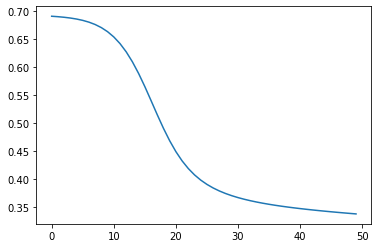

In [43]:
fig, ax = plt.subplots()
ax.plot(costs)